# DAY 38

在遇到大规模数据集时，显存常常无法一次性存储所有数据，所以需要使用分批训练的方法。为此，PyTorch提供了DataLoader类，该类可以自动将数据集切分为多个批次batch，并支持多线程加载数据。此外，还存在Dataset类，该类可以定义数据集的读取方式和预处理方式。


1. DataLoader类：决定数据如何加载
2. Dataset类：告诉程序去哪里找数据，如何读取单个样本，以及如何预处理。



为了引入这些概念，我们现在接触一个新的而且非常经典的数据集：MNIST手写数字数据集。该数据集包含60000张训练图片和10000张测试图片，每张图片大小为28*28像素，共包含10个类别。因为每个数据的维度比较小，所以既可以视为结构化数据，用机器学习、MLP训练，也可以视为图像数据，用卷积神经网络训练。

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader , Dataset # DataLoader 是 PyTorch 中用于加载数据的工具
from torchvision import datasets, transforms # torchvision 是一个用于计算机视觉的库，datasets 和 transforms 是其中的模块
import matplotlib.pyplot as plt

# 设置随机种子，确保结果可复现
torch.manual_seed(42)

```
torchvision
├── datasets       # 视觉数据集（如 MNIST、CIFAR）
├── transforms     # 视觉数据预处理（如裁剪、翻转、归一化）
├── models         # 预训练模型（如 ResNet、YOLO）
├── utils          # 视觉工具函数（如目标检测后处理）
└── io             # 图像/视频 IO 操作
```

In [22]:
# 1. 数据预处理，该写法非常类似于管道pipeline
# transforms 模块提供了一系列常用的图像预处理操作

# 先归一化，再标准化
transform = transforms.Compose([
    transforms.ToTensor(),  # 转换为张量并归一化到[0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST数据集的均值和标准差，这个值很出名，所以直接使用
])

In [23]:
# 2. 加载MNIST数据集，如果没有会自动下载
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)

这里稍微有点反逻辑，正常思路应该是先有数据集，后续再处理。但是在pytorch的思路是，数据在加载阶段就处理结束。

## 一、Dataset类

现在我们想要取出来一个图片，看看长啥样，因为datasets.MNIST本质上集成了torch.utils.data.Dataset，所以自然需要有对应的方法。

In [24]:
import matplotlib.pyplot as plt

# 随机选择一张图片，可以重复运行，每次都会随机选择
sample_idx = torch.randint(0, len(train_dataset), size=(1,)).item() # 随机选择一张图片的索引
# len(train_dataset) 表示训练集的图片数量；size=(1,)表示返回一个索引；torch.randint() 函数用于生成一个指定范围内的随机数,item() 方法将张量转换为 Python 数字
image, label = train_dataset[sample_idx] # 获取图片和标签

这里很难理解，为什么train_dataset[sample_idx]可以获取到图片和标签，是因为 datasets.MNIST这个类继承了torch.utils.data.Dataset类，这个类中有一个方法__getitem__，这个方法会返回一个tuple，tuple中第一个元素是图片，第二个元素是标签。

我们来详细介绍下torch.utils.data.Dataset类

PyTorch 的torch.utils.data.Dataset是一个抽象基类，所有自定义数据集都需要继承它并实现两个核心方法：

- __len__()：返回数据集的样本总数。
- __getitem__(idx)：根据索引idx返回对应样本的数据和标签。

PyTorch 要求所有数据集必须实现__getitem__和__len__，这样才能被DataLoader等工具兼容。这是一种接口约定，类似函数参数的规范。这意味着，如果你要创建一个自定义数据集，你需要实现这两个方法，否则PyTorch将无法识别你的数据集。

在 Python 中，__getitem__和__len__ 是类的特殊方法（也叫魔术方法 ），它们不是像普通函数那样直接使用，而是需要在自定义类中进行定义，来赋予类特定的行为。以下是关于这两个方法具体的使用方式：

### __getitem__方法
__getitem__方法用于让对象支持索引操作，当使用[]语法访问对象元素时，Python 会自动调用该方法。

In [25]:
# 示例代码
class MyList:
    def __init__(self):
        self.data = [10, 20, 30, 40, 50]

    def __getitem__(self, idx):
        return self.data[idx]

# 创建类的实例
my_list_obj = MyList()
# 此时可以使用索引访问元素，这会自动调用__getitem__方法
print(my_list_obj[2])  # 输出：30

30


通过定义__getitem__方法，让MyList类的实例能够像 Python 内置的列表一样使用索引获取元素。

### __len__方法

__len__方法用于返回对象中元素的数量，当使用内置函数len()作用于对象时，Python 会自动调用该方法。

In [26]:
class MyList:
    def __init__(self):
        self.data = [10, 20, 30, 40, 50]

    def __len__(self):
        return len(self.data)

# 创建类的实例
my_list_obj = MyList()
# 使用len()函数获取元素数量，这会自动调用__len__方法
print(len(my_list_obj))  # 输出：5

5


这里定义的__len__方法，使得MyList类的实例可以像普通列表一样被len()函数调用获取长度。

In [27]:

# minist数据集的简化版本
class MNIST(Dataset):
    def __init__(self, root, train=True, transform=None):
        # 初始化：加载图片路径和标签
        self.data, self.targets = fetch_mnist_data(root, train) # 这里假设 fetch_mnist_data 是一个函数，用于加载 MNIST 数据集的图片路径和标签
        self.transform = transform # 预处理操作
        
    def __len__(self): 
        return len(self.data)  # 返回样本总数
    
    def __getitem__(self, idx): # 获取指定索引的样本
        # 获取指定索引的图像和标签
        img, target = self.data[idx], self.targets[idx]
        
        # 应用图像预处理（如ToTensor、Normalize）
        if self.transform is not None: # 如果有预处理操作
            img = self.transform(img) # 转换图像格式
        # 这里假设 img 是一个 PIL 图像对象，transform 会将其转换为张量并进行归一化
            
        return img, target  # 返回处理后的图像和标签

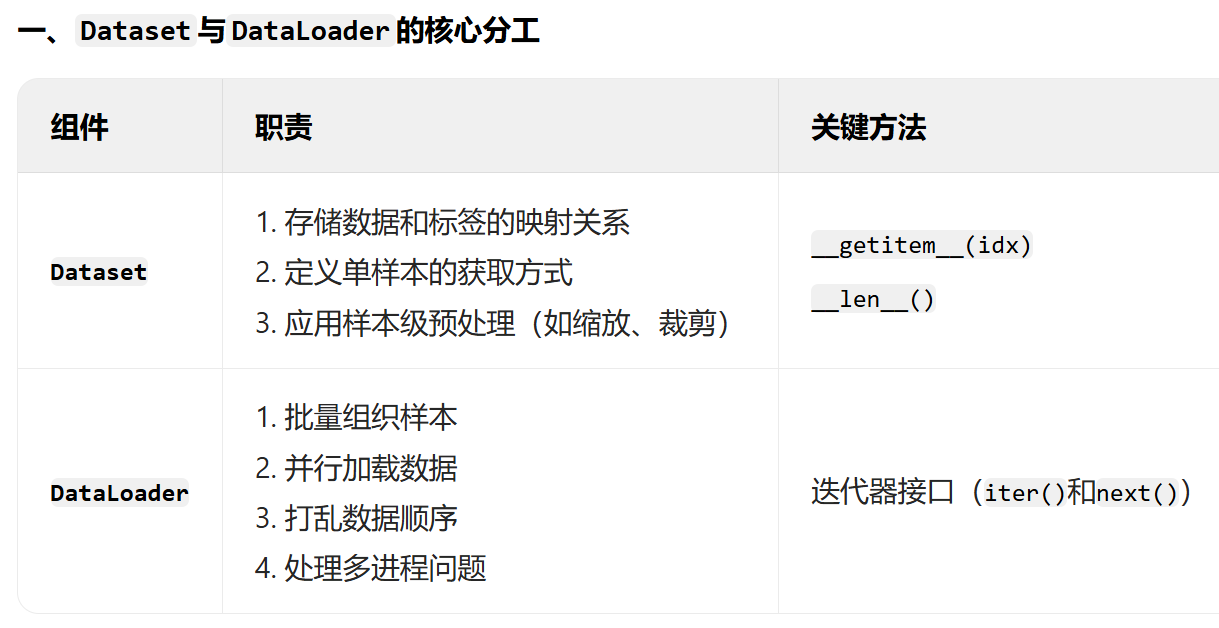

- Dataset = 厨师（准备单个菜品）
- DataLoader = 服务员（将菜品按订单组合并上桌）
  
预处理（如切菜、调味）属于厨师的工作，而非服务员。所以在dataset就需要添加预处理步骤。

Label: 6


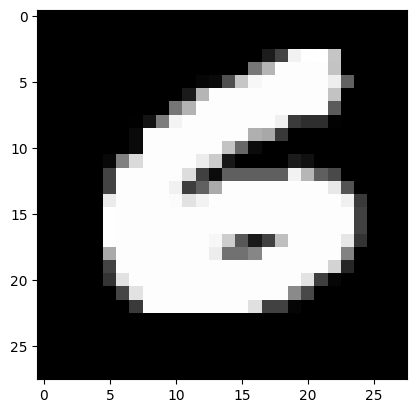

In [28]:
# 可视化原始图像（需要反归一化）
def imshow(img):
    img = img * 0.3081 + 0.1307  # 反标准化
    npimg = img.numpy()
    plt.imshow(npimg[0], cmap='gray') # 显示灰度图像
    plt.show()

print(f"Label: {label}")
imshow(image)

## 二、Dataloader类

该类比较简单，很好理解

In [29]:
# 3. 创建数据加载器
train_loader = DataLoader(
    train_dataset,
    batch_size=64, # 每个批次64张图片,一般是2的幂次方，这与GPU的计算效率有关
    shuffle=True # 随机打乱数据
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1000 # 每个批次1000张图片
    # shuffle=False # 测试时不需要打乱数据
)

## 三、总结


| **维度**         | **`Dataset`**                              | **`DataLoader`**                          |
|------------------|--------------------------------------------|-------------------------------------------|
| **核心职责**      | 定义“数据是什么”和“如何获取单个样本”       | 定义“如何批量加载数据”和“加载策略”        |
| **核心方法**      | `__getitem__`（获取单个样本）、`__len__`（样本总数） | 无自定义方法，通过参数控制加载逻辑        |
| **预处理位置**    | 在`__getitem__`中通过`transform`执行预处理 | 无预处理逻辑，依赖`Dataset`返回的预处理后数据 |
| **并行处理**      | 无（仅单样本处理）                         | 支持多进程加载（`num_workers>0`）          |
| **典型参数**      | `root`（数据路径）、`transform`（预处理）  | `batch_size`、`shuffle`、`num_workers`     |

**核心结论**
- **`Dataset`类**：定义数据的**内容和格式**（即“如何获取单个样本”），包括：
  - 数据存储路径/来源（如文件路径、数据库查询）。
  - 原始数据的读取方式（如图像解码为PIL对象、文本读取为字符串）。
  - 样本的预处理逻辑（如裁剪、翻转、归一化等，通常通过`transform`参数实现）。
  - 返回值格式（如`(image_tensor, label)`）。

- **`DataLoader`类**：定义数据的**加载方式和批量处理逻辑**（即“如何高效批量获取数据”），包括：
  - 批量大小（`batch_size`）。
  - 是否打乱数据顺序（`shuffle`）。
 


